# Climate Data Store (CDS) - Example Backend

**Contains modified Copernicus Climate Change Service Information 2020**
under [License](https://apps.ecmwf.int/datasets/licences/copernicus/)

*Copernicus Climate Change Service (C3S) - Upper Air Data Service (2020)*

The purpose of this IPython Notebook is to demonstrate the access and usability of the proposed data delivering service. Example usage of the Climate Data Store (CDS) Backend for Radiosonde data.

For further information please refer to the Deliverable **DC3S311c_Lot2.3.1.1** on [Github CEUAS](https://github.com/MBlaschek/CEUAS/tree/master/CEUAS/public/cds-backend).


    Author: M. Blaschek
    Date: 01.2020
    Contact: michael.blaschek [at] univie.ac.at
    License: C3S, 2020
    

In [2]:
# check if necessary packages are install
!pip -q install numpy pandas scipy xarray netcdf4 h5py matplotlib numba

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Plotting parameters
plt.rcParams['figure.figsize'] = [12.0, 6.0]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.style.use('seaborn-colorblind')
yplevs = np.array([10,30,70,125,175,225,300,400,500,700,925])*100.

In [5]:
#
# Make sure you have Python 3
#
from platform import python_version
if python_version()[0] != '3':
    print("Your Version:", python_version())
    raise RuntimeError("This Notebook requires Python 3")

# Functionality of the delivering server

The backend expects HTTP POST requests, where the query string must be in JSON format. In the Deliverable Document Table 1 describes the allowed keys and values of the requests. HTTP GET requests may work as well but are accepted only for debugging.

The backend returns files, which are either
1. Zip files containing CF 1.7 compliant netCDF4 files  (one per station). The default name is download.zip.
2. JSON files containing error messages, if a HTTP error occurs


The interface can be a pure python code or via a linux shell.

* [Python Interface](#Python-version)
* [Shell Interface](#Shell)


A typical request should contain:
1. **statid** - the Station Identifier
    * e.g. `'11035' or ['11035','72357'] or 'all'`
2. **date** - datetime selection YYYYMMDD
    * e.g. `one day 19990101 or a range [19990101, 19991231]`
3. **pressure_level** - selection of pressure levels
    * e.g. `one level [85000] or [50000, 85000] or no keyword for all significant levels`
4. **variable** - selection of variables 
    * e.g. `'temperature', 'relative_humidity', ...`
5. **fbstats**  - feedback information from reanalysis
    * e.g. `'obs_minus_an', obs_minus_fg', ...`

## Python version

The requested data can be unzippped in memory to a data directory.

In [6]:
import requests, zipfile, io, os, time
t0 = time.time()
# http://early-upper-air.copernicus-climate.eu
# http://srvx8.img.univie.ac.at:8004
r = requests.post('http://early-upper-air.copernicus-climate.eu',
                  headers={'content-type': 'application/json'},
                  json={"statid": "11035",
                        "date": [20000101, 20000101],
                        "pressure_level": [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000,
                                           50000, 70000, 85000, 92500, 100000],
                        "variable": ["temperature", "relative_humidity"],
                        "fbstats": ["obs_minus_bg", "obs_minus_an", "bias_estimate"]
                        },
                  stream=True)
#
# Check for known Error Message
#
if r.status_code != requests.codes.ok:
     print(r.text)
     raise RuntimeError("Something is not correct with the request")
#
# Create directory
#
if not os.path.isdir('./example_data'):
    os.makedirs('./example_data')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Unzipping retrieved files: to ./exampla_data")
    print(z.namelist())
    z.extractall(path='./example_data')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

Unzipping retrieved files: to ./exampla_data
['dest_11035_air_temperature.nc', 'dest_11035_relative_humidity.nc']
Time elapsed:  0.33086180686950684 s


## Shell

Another Way can be use a Linux tool called `curl` to download a zipfile. 
The request (`--data ...`) is identical to the above python request and also the retrieved file is identical. The retrieved file needs to be unzipped.


In [6]:
!curl -H "Content-Type: application/json" -X POST --digest --data '{"statid":"11035","date":[20000101,20000101],"pressure_level":[1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000],"variable":["temperature","relative_humidity"],"fbstats":["obs_minus_bg","obs_minus_an","bias_estimate"]}' -o example_data/download.zip http://early-upper-air.copernicus-climate.eu

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 77298  100 77022  100   276   242k    890 --:--:-- --:--:-- --:--:--  242k


In [7]:
# The retrieved zipfile can be extracted:
!test -e example_data/download.zip && unzip -o example_data/download.zip -d example_data && rm example_data/download.zip

Archive:  example_data/download.zip
 extracting: example_data/dest_11035_air_temperature.nc  
 extracting: example_data/dest_11035_relative_humidity.nc  


In [12]:
# Show the new downloaded files in example_data directory
!ls -Rlh

.:
insgesamt 316K
drwxr-xr-x. 2 mblaschek users  102  3. Feb 11:10 code
drwxr-xr-x. 2 mblaschek users   80  3. Feb 11:29 example_data
-rw-r--r--. 1 mblaschek users 302K  3. Feb 11:28 Example.ipynb
-rw-r--r--. 1 mblaschek users 7,1K  3. Feb 11:10 README.md
-rw-r--r--. 1 mblaschek users  161 31. Jän 13:50 requirements.txt

./code:
insgesamt 64K
-rw-r--r--. 1 mblaschek users  33K 31. Jän 13:19 cds_eua.py
-rw-r--r--. 1 mblaschek users  16K  3. Feb 11:10 default.py
-rw-r--r--. 1 mblaschek users  143 31. Jän 10:46 README.md
-rw-r--r--. 1 mblaschek users   95 31. Jän 10:42 requirements.txt
-rw-r--r--. 1 mblaschek users 1,6K 31. Jän 13:19 upload_to_vm.ksh

./example_data:
insgesamt 80K
-rw-r--r--. 1 mblaschek users 38K  3. Feb 10:29 dest_11035_air_temperature.nc
-rw-r--r--. 1 mblaschek users 38K  3. Feb 10:29 dest_11035_relative_humidity.nc


# Retrieved files

In [7]:
import xarray as xr

In [8]:
# Open Netcdf with Xarray
tdata = xr.open_dataset('example_data/dest_11035_air_temperature.nc')
tdata

<xarray.Dataset>
Dimensions:           (obs: 31, trajectory: 2)
Coordinates:
    lat               (obs) float32 ...
    lon               (obs) float32 ...
    plev              (obs) float32 ...
    time              (obs) datetime64[ns] ...
Dimensions without coordinates: obs, trajectory
Data variables:
    bias_estimate     (obs) float32 ...
    obs_minus_an      (obs) float32 ...
    obs_minus_bg      (obs) float32 ...
    ta                (obs) float32 ...
    trajectory_index  (obs) int32 ...
    trajectory_label  (trajectory) |S5 ...
Attributes:
    primary_id:    0-20000-0-11035
    station_name:  WIEN/HOHE WARTE (11035-0)
    Conventions:   CF-1.7
    source:        radiosonde
    featureType:   trajectory
    history:       Created by Copernicus Early Upper Air Service Version 0, 2...
    license:       https://apps.ecmwf.int/datasets/licences/copernicus/

## Variables

Notice that there are the following variables:
* `bias_estimate` - Reanalysis Bias estimate
* `obs_min_an` - Analysis Departures
* `obs_min_bg` - First Guess Departures
* `ta` - Observations, e.g. Air Temperature
* `trajectory_index` - unique profile identifier, where each observation belongs to
* `trajectory_label` - unique profile label, as in the CDM tables

Notice as well the differen Coordinates and Dimensions:
* `obs` - Dimension that corresponds to a record lenght (all profiles together)
* `trajectory`  - Dimension that corresponds to a number of individual profiles
* `lat` - Coordinate Information Latitude
* `lon` - Coordinate Information Longitude
* `plev` - Coordinate Information pressure
* `time` - Coordinate Information time

# Request a profile

Tasks:
* One station: `11035`
* One datetime: `20000101`
* Two variables: `temperature, relative humidity`
* Notice no `pressure_level`, thus requesting significant level data.

In [9]:
import requests, zipfile, io, os, time
t0 = time.time()
# http://early-upper-air.copernicus-climate.eu
#
# All levels for one day
#
r = requests.post('http://early-upper-air.copernicus-climate.eu',
                  headers={'content-type': 'application/json'},
                  json={"statid": "11035",
                        "date": [20000101, 20000101],
                        "variable": ["temperature", "relative_humidity"]
                        },
                  stream=True)
#
# Check for known Error Message
#
if r.status_code != requests.codes.ok:
     print(r.text)
     raise RuntimeError("Something is not correct with the request")
#
# Create directory
#
if not os.path.isdir('./example_data'):
    os.makedirs('./example_data')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Retreived files: ")
    print(z.namelist())
    z.extractall(path='./example_data')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

Retreived files: 
['dest_11035_air_temperature.nc', 'dest_11035_relative_humidity.nc']
Time elapsed:  0.3341336250305176 s


## Read the NetCDF to xarray

In [11]:
# In case of NetCDF error might need to run again (unknown bug)
tdata = xr.load_dataset('example_data/dest_11035_air_temperature.nc')
rdata = xr.load_dataset('example_data/dest_11035_relative_humidity.nc')

In [12]:
# This is the xarray representation of the NetCDF file
tdata

<xarray.Dataset>
Dimensions:           (obs: 190, trajectory: 2)
Coordinates:
    lat               (obs) float32 48.23 48.23 48.23 ... 48.23 48.23 48.23
    lon               (obs) float32 16.37 16.37 16.37 ... 16.37 16.37 16.37
    plev              (obs) float32 590.0 660.0 760.0 ... 95700.0 97400.0
    time              (obs) datetime64[ns] 2000-01-01 ... 2000-01-01T12:00:00
Dimensions without coordinates: obs, trajectory
Data variables:
    ta                (obs) float32 211.3 nan 206.5 205.9 ... 269.7 271.9 nan
    trajectory_index  (obs) int32 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
    trajectory_label  (trajectory) |S5 b'30635' b'30637'
Attributes:
    primary_id:    0-20000-0-11035
    station_name:  WIEN/HOHE WARTE (11035-0)
    Conventions:   CF-1.7
    source:        radiosonde
    featureType:   trajectory
    history:       Created by Copernicus Early Upper Air Service Version 0, 2...
    license:       https://apps.ecmwf.int/datasets/licences/copernicus/

## Plot a profile

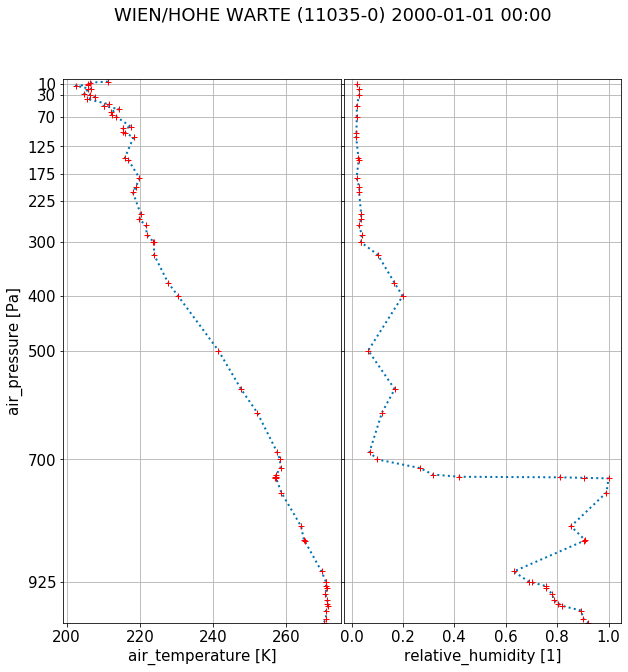

In [13]:
#
# Select 00Z, change dimension to pressure, drop missing values
#
plotdata = tdata.sel(obs=tdata.time.dt.hour==0).ta.swap_dims({'obs':'plev'}).to_dataset()
plotdata['hur'] = rdata.sel(obs=rdata.time.dt.hour==0).hur.swap_dims({'obs':'plev'})
#
# Plotting
#
f, [ax,ay] = subplots(1,2, sharey=True, figsize=(10,10))
plotdata.ta.dropna('plev').plot(y='plev', marker='+', ls=':', mec='red', ax=ax)
plotdata.hur.dropna('plev').plot(y='plev', marker='+', ls=':', mec='red', ax=ay)
# ax.set_yscale('log')
ax.set_yticks(ticks=yplevs)
ax.set_yticklabels(map("{:.0f}".format,yplevs/100))
ax.set_ylim(100000,100)
ay.set_ylim(100000,100)
ax.grid()
ay.grid()
ay.set_ylabel('')
subplots_adjust(wspace=0.01)
f.suptitle("{} {}".format(tdata.attrs['station_name'], plotdata.time.dt.strftime("%Y-%m-%d %H:%M").item(0)),);

# Request a timeseries

Tasks:
* One Station: `11035`
* Datetime range: `20000101 - 20181231`
* Two variables: `temperature, relative humidity`
* One pressure level: `85000`


In [14]:
import requests, zipfile, io, os, time
t0 = time.time()
# http://early-upper-air.copernicus-climate.eu
r = requests.post('http://early-upper-air.copernicus-climate.eu',
                  headers={'content-type': 'application/json'},
                  json={"statid": "11035",
                        "date": [20000101, 20180101],
                        "variable": ["temperature", "relative_humidity"],
                        "pressure_level": [85000, 85000]
                        },
                  stream=True)
#
# Check for known Error Message
#
if r.status_code != requests.codes.ok:
     print(r.text)
     raise RuntimeError("Something is not correct with the request")
#
# Create directory
#
if not os.path.isdir('./example_data'):
    os.makedirs('./example_data')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Retreived files: ")
    print(z.namelist())
    z.extractall(path='./example_data')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

Retreived files: 
['dest_11035_air_temperature.nc', 'dest_11035_relative_humidity.nc']
Time elapsed:  3.050874948501587 s


## Read NetCDF to xarray

In [15]:
tdata = xr.load_dataset('example_data/dest_11035_air_temperature.nc')
rdata = xr.load_dataset('example_data/dest_11035_relative_humidity.nc')

In [16]:
# Again the representation of the NetCDF file, 
# Notice the number of trajectories (13879), this is basically the amount of profiles in the file.
tdata

<xarray.Dataset>
Dimensions:           (obs: 15933, trajectory: 13879)
Coordinates:
    lat               (obs) float32 48.23 48.23 48.23 ... 48.24895 48.24895
    lon               (obs) float32 16.37 16.37 16.37 ... 16.35718 16.35718
    plev              (obs) float32 85000.0 85000.0 85000.0 ... 85000.0 85000.0
    time              (obs) datetime64[ns] 2000-01-01 ... 2018-01-01T23:30:27
Dimensions without coordinates: obs, trajectory
Data variables:
    ta                (obs) float32 265.1 266.3 267.9 ... 273.66 273.48 273.48
    trajectory_index  (obs) int32 0 1 2 3 4 5 ... 13876 13877 13877 13878 13878
    trajectory_label  (trajectory) |S5 b'30635' b'30637' ... b'53290' b'53291'
Attributes:
    primary_id:    0-20000-0-11035
    station_name:  WIEN/HOHE WARTE (11035-0)
    Conventions:   CF-1.7
    source:        radiosonde
    featureType:   trajectory
    history:       Created by Copernicus Early Upper Air Service Version 0, 2...
    license:       https://apps.ecmwf.int/datasets/licences/copernicus/

## Plot a timeseries

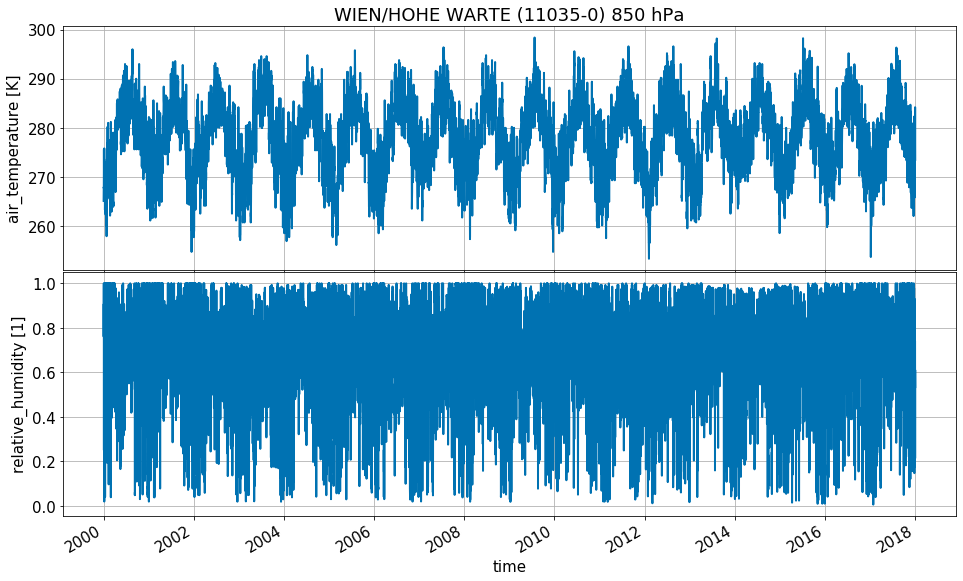

In [17]:
#
# Select 00Z, change dimension to pressure, drop missing values
#
plotdata = tdata.ta.swap_dims({'obs':'time'}).to_dataset()
plotdata['hur'] = rdata.hur.swap_dims({'obs':'time'})
#
# Plotting
#
f, [ax,ay] = subplots(2,1, sharex=True, figsize=(16,9))
plotdata.ta.dropna('time').plot(x='time', ax=ax)
plotdata.hur.dropna('time').plot(x='time', ax=ay)
ax.grid()
ax.set_xlabel('')
ay.grid()
subplots_adjust(hspace=0.01)
ax.set_title("{} {:.0f} hPa".format(tdata.attrs['station_name'], plotdata.plev.values[0]/100));

# Request multiple Stations

Tasks:
* 4 Stations: `11035,11010,11120,11240`
    - Vienna, Linz, Innsbruck and Graz. Four Stations from Austria
* One day: `20000101 - 20000101`
* Two variables: `temperature, relative humidity`
* One pressure level: `85000`

In [ ]:
import requests, zipfile, io, os, time
t0 = time.time()
# http://early-upper-air.copernicus-climate.eu
r = requests.post('http://early-upper-air.copernicus-climate.eu',
                  headers={'content-type': 'application/json'},
                  json={"statid": ["11035", "11010", "11120", "11240"],
                        "date": [20000101, 20000101],
                        "variable": ["temperature", "relative_humidity"],
                        "pressure_level": [85000, 85000]
                        },
                  stream=True)
#
# Check for known Error Message
#
if r.status_code != requests.codes.ok:
     print(r.text)
     raise RuntimeError("Something is not correct with the request")
#
# Create directory
#
if not os.path.isdir('./example_data'):
    os.makedirs('./example_data')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Retreived files: ")
    print(z.namelist())
    z.extractall(path='./example_data')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

## Read NetCDF to xarray

In [20]:
data = {}
for ifile in os.listdir('./example_data/'):
    ident = ifile.split('_')[1]
    
    if ident not in data.keys():
        data[ident] = []
    #
    # Load the NetCDF data
    #
    tmp = xr.load_dataset('./example_data/' + ifile)
    #
    # Add Sonde ID as coordinate
    #
    tmp.coords['sonde'] = ident
    #
    # Drop
    #
    tmp = tmp.drop(['trajectory_index', 'trajectory_label'])
    #
    # Use time as dimension
    #
    tmp = tmp.swap_dims({'obs':'time'})
    data[ident].append(tmp)
#
# Merge Variables per Sonde into one Dataset
#
for ikey in data.keys():
    data[ikey] = xr.merge(data[ikey])
#
# Make a larger dataset
#
data = xr.concat(data.values(), dim='sonde')

In [21]:
data

<xarray.Dataset>
Dimensions:  (sonde: 4, time: 4)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T12:00:00
    lat      (sonde, time) float32 48.23 nan nan 48.23 nan ... nan 47.0 nan nan
    lon      (sonde, time) float32 16.37 nan nan 16.37 nan ... nan 15.43 nan nan
    plev     (sonde, time) float32 85000.0 nan nan 85000.0 ... 85000.0 nan nan
  * sonde    (sonde) object '11035' '11010' '11120' '11240'
Data variables:
    ta       (sonde, time) float32 265.1 nan nan 266.3 nan ... nan 265.7 nan nan
    hur      (sonde, time) float32 0.903358 nan nan ... 0.771899 nan nan

## Merged Dataset

Notice that we have 4 Sondes and 4 times. This happens because the reported times are launch times. 

We can have a look at the temperature information. 
1. Vienna (11035) has soundings at 00Z and 12Z
2. Linz (11010) has one sounding at 05Z
3. Innsbruck (11120) has one sounding at 00Z
4. Graz (11240) has one sounding at 04Z

In [22]:
print(data.ta)

<xarray.DataArray 'ta' (sonde: 4, time: 4)>
array([[265.1,   nan,   nan, 266.3],
       [  nan,   nan, 266.9,   nan],
       [266.5,   nan,   nan,   nan],
       [  nan, 265.7,   nan,   nan]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T12:00:00
    lat      (sonde, time) float32 48.23 nan nan 48.23 nan ... nan 47.0 nan nan
    lon      (sonde, time) float32 16.37 nan nan 16.37 nan ... nan 15.43 nan nan
    plev     (sonde, time) float32 85000.0 nan nan 85000.0 ... 85000.0 nan nan
  * sonde    (sonde) object '11035' '11010' '11120' '11240'
Attributes:
    cdmname:        observations_table/observation_value
    units:          K
    standard_name:  air_temperature
    cdsname:        temperature


In [23]:
# Vienna
print(data.sel(sonde='11035').dropna('time'))

<xarray.Dataset>
Dimensions:  (time: 2)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-01T12:00:00
    lat      (time) float32 48.23 48.23
    lon      (time) float32 16.37 16.37
    plev     (time) float32 85000.0 85000.0
    sonde    <U5 '11035'
Data variables:
    ta       (time) float32 265.1 266.3
    hur      (time) float32 0.903358 0.760778


In [24]:
# Lins
print(data.sel(sonde='11010').dropna('time'))

<xarray.Dataset>
Dimensions:  (time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T05:00:00
    lat      (time) float32 48.23
    lon      (time) float32 14.18
    plev     (time) float32 85000.0
    sonde    <U5 '11010'
Data variables:
    ta       (time) float32 266.9
    hur      (time) float32 0.837089


## Preparing plotdata

In order to have a common datetime we choose here to interpolate to 06Z as a common time.
To do this be need to fill the missing information and linearly interpolate to the time:
1. `interpolate_na`, interpolate missing values, only possible for Vienna, because 04Z and 05Z lie between 00Z and 12Z.
2. `ffill`, forward fill, copies the information to other times.
3. `interp`, linearly interpolates to the wanted time 06Z.
    - Note only for Vienna the value is interpolated between 05Z and 12Z

In [25]:
plotdata = data.interpolate_na('time')  # Interpolate
plotdata

/raid8/srvx1/mblaschek/.conda/envs/bunnies/lib/python3.7/site-packages/xarray/core/missing.py:251: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  ).transpose(*self.dims)
/raid8/srvx1/mblaschek/.conda/envs/bunnies/lib/python3.7/site-packages/xarray/core/missing.py:251: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  ).transpose(*self.dims)


<xarray.Dataset>
Dimensions:  (sonde: 4, time: 4)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T12:00:00
    lon      (sonde, time) float32 16.37 nan nan 16.37 nan ... nan 15.43 nan nan
    plev     (sonde, time) float32 85000.0 nan nan 85000.0 ... 85000.0 nan nan
  * sonde    (sonde) object '11035' '11010' '11120' '11240'
    lat      (sonde, time) float32 48.23 nan nan 48.23 nan ... nan 47.0 nan nan
Data variables:
    ta       (sonde, time) float32 265.1 265.5 265.6 266.3 ... nan 265.7 nan nan
    hur      (sonde, time) float32 0.903358 0.8558313 0.8439497 ... nan nan

In [26]:
# reset_coords make lon, lat to variables and allows them to be filled as well, set_coords make lat,lon coordinates again, but filled with information now.
plotdata = plotdata.reset_coords(['lon', 'lat']).ffill('time').bfill('time').set_coords(['lon', 'lat'])
plotdata

/raid8/srvx1/mblaschek/.conda/envs/bunnies/lib/python3.7/site-packages/xarray/core/missing.py:307: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  ).transpose(*arr.dims)
/raid8/srvx1/mblaschek/.conda/envs/bunnies/lib/python3.7/site-packages/xarray/core/missing.py:324: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  ).transpose(*arr.dims)


<xarray.Dataset>
Dimensions:  (sonde: 4, time: 4)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T12:00:00
  * sonde    (sonde) object '11035' '11010' '11120' '11240'
    plev     (sonde, time) float32 85000.0 nan nan 85000.0 ... 85000.0 nan nan
    lon      (sonde, time) float32 16.37 16.37 16.37 16.37 ... 15.43 15.43 15.43
    lat      (sonde, time) float32 48.23 48.23 48.23 48.23 ... 47.0 47.0 47.0
Data variables:
    ta       (sonde, time) float32 265.1 265.5 265.6 266.3 ... 265.7 265.7 265.7
    hur      (sonde, time) float32 0.903358 0.8558313 ... 0.771899 0.771899

In [27]:
plotdata = plotdata.interp(time='2000-01-01 06:00:00')
plotdata

<xarray.Dataset>
Dimensions:  (sonde: 4)
Coordinates:
  * sonde    (sonde) object '11035' '11010' '11120' '11240'
    plev     (sonde) float64 nan nan nan nan
    lon      (sonde) float64 16.37 14.18 11.35 15.43
    lat      (sonde) float64 48.23 48.23 47.27 47.0
    time     datetime64[ns] 2000-01-01T06:00:00
Data variables:
    ta       (sonde) float64 265.7 266.9 266.5 265.7
    hur      (sonde) float64 0.8321 0.8371 0.8366 0.7719

## Plot a map

In [28]:
# Cartopy can not easily be installed on Colab
import cartopy.crs as ccrs
import cartopy as cpy

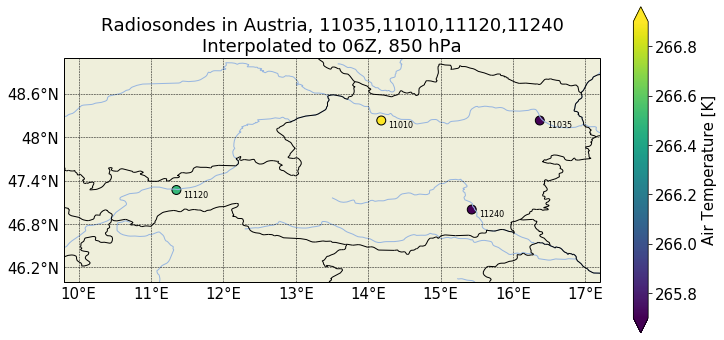

In [29]:
#
# Define the Plot
#
ax = plt.subplot(projection=ccrs.PlateCarree());
#
# Add Metainformation
#
ax.add_feature(cpy.feature.LAND, zorder=0)
ax.add_feature(cpy.feature.LAKES.with_scale('10m'), zorder=0)
ax.add_feature(cpy.feature.RIVERS.with_scale('10m'), zorder=1)
ax.add_feature(cpy.feature.BORDERS.with_scale('10m'), zorder=1)
#
# Plot the Values
#
cs = ax.scatter(plotdata.lon.values, plotdata.lat.values, 
                s=80,
                c=plotdata.ta.values,
                edgecolor='k',
                transform=ccrs.PlateCarree());
#
# Colorbar
#
cb = plt.colorbar(cs, ax=ax, extend='both')
cb.set_label("Air Temperature [K]")
ax.set_extent([9.8,17.2,46,49.1])   # set the extent of the map
#
# Add Labels
#
lloffset = [0.1]*4
for i, j, l, k in zip(plotdata.lon.values, plotdata.lat.values, plotdata.sonde.values, lloffset):
    ax.text(i + k, j, "{}".format(l), horizontalalignment='left', verticalalignment='top',
            transform=cpy.crs.PlateCarree(), fontsize=8, zorder=12,
            clip_on=True)

ax.set_title("Radiosondes in Austria, " + ",".join(plotdata.sonde.values) + "\nInterpolated to 06Z, 850 hPa");
#
# Gird lines
#
gl = ax.gridlines(draw_labels=True, xlocs=None, ylocs=None,
                  linewidth=0.5, linestyle='--', color='k')
gl.xformatter = cpy.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cpy.mpl.gridliner.LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False

# Request a timeseries and convert to cube


Tasks:
* One Station: `11035`
* Datetime range: `20000101 - 20181231`
* One variables: `temperature`
* Background Departures: `obs_minus_bg, obs_minus_an, bias_estimate`
* Standard pressure levels (#16)


In [25]:
import requests, zipfile, io, os, time
t0 = time.time()
# http://early-upper-air.copernicus-climate.eu
r = requests.post('http://early-upper-air.copernicus-climate.eu',
                  headers={'content-type': 'application/json'},
                  json={"statid": "11035",
                        "date": [20000101, 20180101],
                        "variable": ["temperature"],
                        "pressure_level": [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000,
                                           50000, 70000, 85000, 92500, 100000],
                        "fbstats": ["obs_minus_bg", "obs_minus_an", "bias_estimate"]
                        },
                  stream=True)
#
# Check for known Error Message
#
if r.status_code != requests.codes.ok:
     print(r.text)
     raise RuntimeError("Something is not correct with the request")
#
# Create directory
#
if not os.path.isdir('./example_data'):
    os.makedirs('./example_data')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Retreived files: ")
    print(z.namelist())
    z.extractall(path='./example_data')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

Retreived files: 
['dest_11035_air_temperature.nc']
Time elapsed:  5.017395734786987 s


## Conversion Function from ragged array to cube

This function can also be found here: [cds-backend](https://github.com/MBlaschek/CEUAS/tree/master/CEUAS/public/cds-backend/code)

In [30]:
def read_ragged_array_to_cube(filename, dim='time', lev='plev', variables=None, std_plevs=None, **kwargs):
    """
    The function reads a CF compliant upper air data file from the CDS backend and transforms the data into
    a three dimensional data cube with dimensions hour (2), plev (16), time (days).
    This representation is convienient for statistical breakpoint analysis.
    
    Args:
        filename (str): Input NetCDF file
        dim (str): Name of datetime dimension in file
        lev (str): Name of pressure dimension in file
        variables (list): List of variables to read
        std_plevs (list): List of pressure levels to use, default 16

    Returns:
        xarray.Dataset : variables and coordinates and metadata
    
    Note:
        At the moment this function is limited to 00 and 12 UTZ, intermediate times might overlap
    """
    import os
    import h5py 
    import numpy as np
    import pandas as pd
    import xarray as xr
    
    if not os.path.isfile(filename):
        raise IOError('File can not be found', filename)
    
    # standard pressure levels
    if std_plevs is None:
        std_plevs = [10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 700, 850, 925, 1000]
    else:
        print("Standard pressure levels need to be in hPa")
    
    # Pressure Array -> indices
    ip = np.zeros(1001, dtype=np.int32)
    for i,j in enumerate(std_plevs):
        ip[j] = i
    
    data = {}    
    with h5py.File(filename, 'r') as f:
        # time
        time = f[dim][:]  # should be seconds since 1900 01 01
        if 'units' not in f[dim].attrs.keys():
            print("Datetime dimension", dim, "has no units!!! Assuming seconds")
        else:
            if 'seconds' not in f[dim].attrs['units'].decode():
                raise RuntimeError("Datetime dimension", dim, "not in seconds since ????",  f[dim].attrs['units'].decode())
        # pressure
        plev = f[lev][:].astype(np.int32)//100  # requires hPa
        # Calculate Indices for cube positions
        date_index = np.array(time // 86400, dtype=np.int32)
        date_index -= date_index[0]   # index to 0
        hour_index = np.array(((time+21600)%86400)//43200,dtype=np.int32)
        plev_index = ip[plev]  
        # Convert time unit to datetime
        time_unit = f['time'].attrs['units'].decode() if 'units' in f[dim].attrs.keys() else 'seconds since 1900-01-01 00:00:00'
        time = pd.to_datetime(time//86400, unit='D', origin=" ".join(time_unit.split(' ')[-2:]))
        new = np.full(date_index.max()+1, '1850-01-01', dtype='datetime64[ns]') # missing date is 1850 -> remove later
        new[date_index] = time.values  # fill in dates
        time = new
        # Variables
        if variables is None:
            variables = list(f.keys())
        # remove dimension and trajectory variables
        variables = [i for i in variables if i not in ['string5', dim, lev, 'trajectory', 'trajectory_index', 'trajectory_label']]            
        # Read data
        for ivar in variables:
            if ivar not in f.keys():
                continue
            # Create Xarray DataArray
            data[ivar] = xr.DataArray(np.full((2,16,time.size), np.nan, dtype=np.float32), coords=([0,12], std_plevs, time), dims=('hour', lev, dim), name=ivar)
            # Use Indices to fill in data
            data[ivar].values[hour_index, plev_index, date_index] = f[ivar][:]
            # Copy Attributes
            data[ivar].attrs.update({i:j.decode() for i,j in f[ivar].attrs.items() if isinstance(j, bytes)})
        # Copy Global and Coordinate Attributes
        global_attributes = {i:j.decode() for i,j in f.attrs.items()}
        coord_attributes = {lev : {i:j.decode() for i,j in f[lev].attrs.items() if isinstance(j, bytes)}}
    
    data = xr.Dataset(data).sortby(dim)
    # remove redundant information
    if 'lat' in data.data_vars:
        data['lat'] = data['lat'].reduce(np.nanmean, ('hour', lev))
    if 'lon' in data.data_vars:
        data['lon'] = data['lon'].reduce(np.nanmean, ('hour', lev))
    # remove missing times
    data = data.sel({dim :slice('1900', None)})
    # set Attributes
    data.attrs.update(global_attributes)
    for i,j in coord_attributes.items():
        data[i].attrs.update(j)
    return data

## Read NetCDF to xarray

In [27]:
tdata = xr.load_dataset('example_data/dest_11035_air_temperature.nc')

In [28]:
tdata

<xarray.Dataset>
Dimensions:           (obs: 238355, trajectory: 14027)
Coordinates:
    lat               (obs) float32 48.23 48.23 48.23 ... 48.24895 48.24895
    lon               (obs) float32 16.37 16.37 16.37 ... 16.35718 16.35718
    plev              (obs) float32 1000.0 2000.0 3000.0 ... 100000.0 100000.0
    time              (obs) datetime64[ns] 2000-01-01 ... 2018-01-01T23:30:27
Dimensions without coordinates: obs, trajectory
Data variables:
    bias_estimate     (obs) float32 0.043947 0.06984 0.092996 ... nan nan
    obs_minus_an      (obs) float32 0.6197 -0.397444 0.371816 ... nan nan
    obs_minus_bg      (obs) float32 0.804497 -0.119601 0.24783 ... nan nan
    ta                (obs) float32 205.9 205.9 206.3 210.1 ... 278.07 nan nan
    trajectory_index  (obs) int32 0 0 0 0 0 0 ... 14026 14026 14026 14026 14026
    trajectory_label  (trajectory) |S5 b'30635' b'30637' ... b'53290' b'53291'
Attributes:
    primary_id:    0-20000-0-11035
    station_name:  WIEN/HOHE WARTE (11035-0)
    Conventions:   CF-1.7
    source:        radiosonde
    featureType:   trajectory
    history:       Created by Copernicus Early Upper Air Service Version 0, 2...
    license:       https://apps.ecmwf.int/datasets/licences/copernicus/

## Read NetCDF to xarray cube

In [31]:
cube = read_ragged_array_to_cube('example_data/dest_11035_air_temperature.nc')

/opt/conda/lib/python3.7/site-packages/xarray/core/variable.py:1535: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)


In [32]:
cube

<xarray.Dataset>
Dimensions:        (hour: 2, plev: 16, time: 6574)
Coordinates:
  * hour           (hour) int64 0 12
  * plev           (plev) int64 10 20 30 50 70 100 ... 400 500 700 850 925 1000
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2018-01-01
Data variables:
    bias_estimate  (hour, plev, time) float32 0.043947 nan 0.043947 ... nan nan
    lat            (time) float32 48.229996 48.229996 ... 48.24895 48.24895
    lon            (time) float32 16.37 16.37 16.37 ... 16.35718 16.35718
    obs            (hour, plev, time) float32 0.0 nan 0.0 0.0 ... 0.0 0.0 0.0
    obs_minus_an   (hour, plev, time) float32 0.6197 nan 3.174401 ... nan nan
    obs_minus_bg   (hour, plev, time) float32 0.804497 nan 3.908963 ... nan nan
    ta             (hour, plev, time) float32 205.9 nan 208.1 ... nan nan nan
Attributes:
    Conventions:   CF-1.7
    featureType:   trajectory
    history:       Created by Copernicus Early Upper Air Service Version 0, 2...
    license:       https://apps.ecmwf.int/datasets/licences/copernicus/
    primary_id:    0-20000-0-11035
    source:        radiosonde
    station_name:  WIEN/HOHE WARTE (11035-0)

## Plot a timeseries

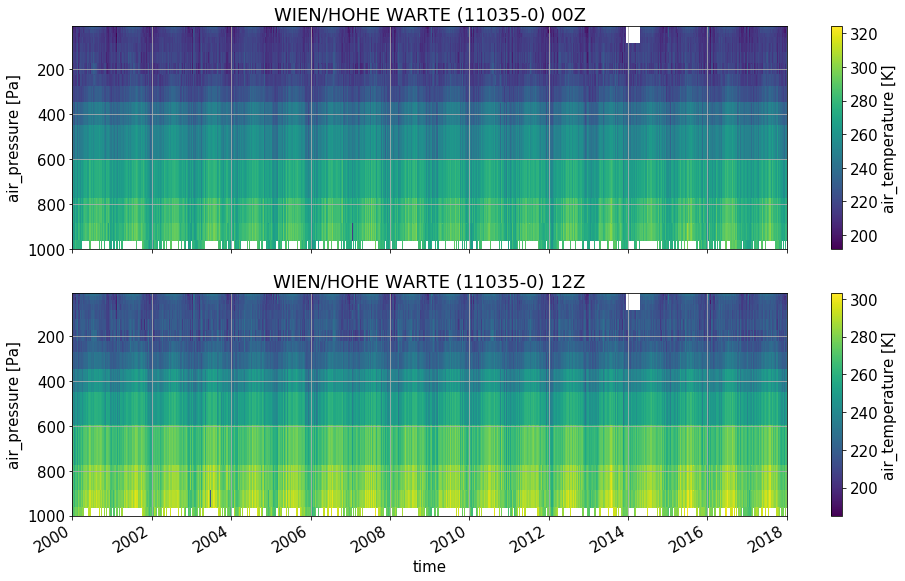

In [33]:
#
# Plotting
#
f, [ax,ay] = subplots(2,1, sharex=True, sharey=True, figsize=(16,9))
cube.sel(hour=0).ta.plot(x='time', y='plev', ax=ax)
cube.sel(hour=12).ta.plot(x='time', y='plev', ax=ay)
ax.grid()
ax.set_xlabel('')
ay.grid()
ax.set_ylim(1000,10)
ax.set_title("{} {:02d}Z".format(tdata.attrs['station_name'], 0));
ay.set_title("{} {:02d}Z".format(tdata.attrs['station_name'], 12));

## Plot a profile

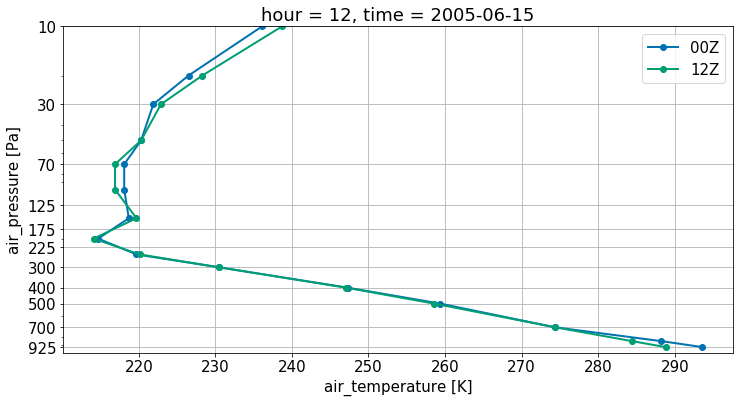

In [34]:
cube.sel(hour=0, time='2005-06-15').ta.plot(y='plev', marker='o', label='00Z')
cube.sel(hour=12, time='2005-06-15').ta.plot(y='plev', marker='o', label='12Z')
ylim(1000,10)
grid()
legend()
yscale('log')
yticks(ticks=yplevs/100, labels=map("{:.0f}".format,yplevs/100));